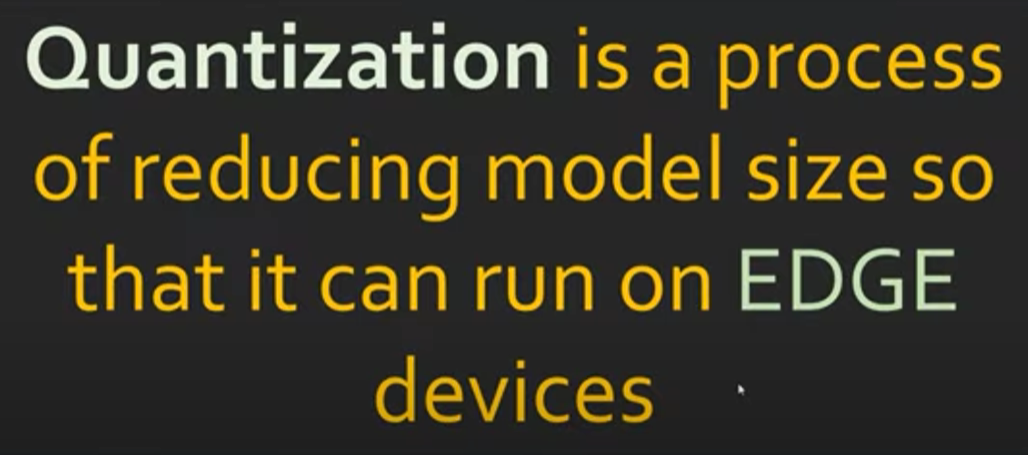

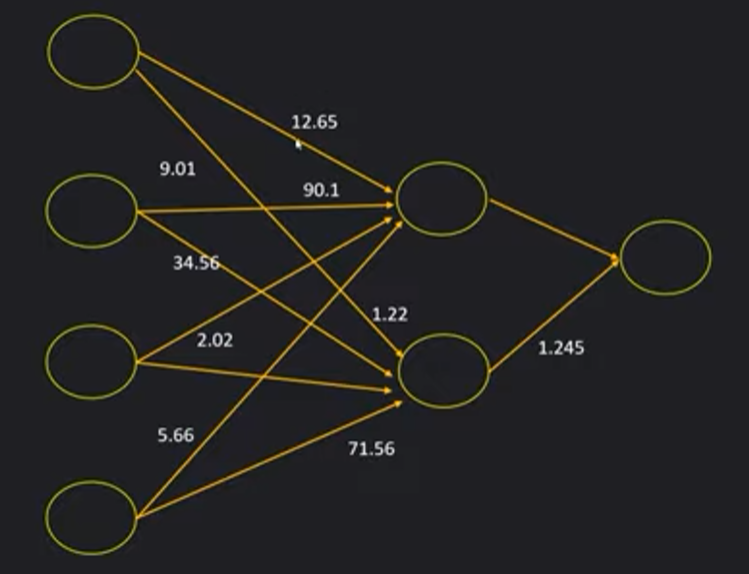

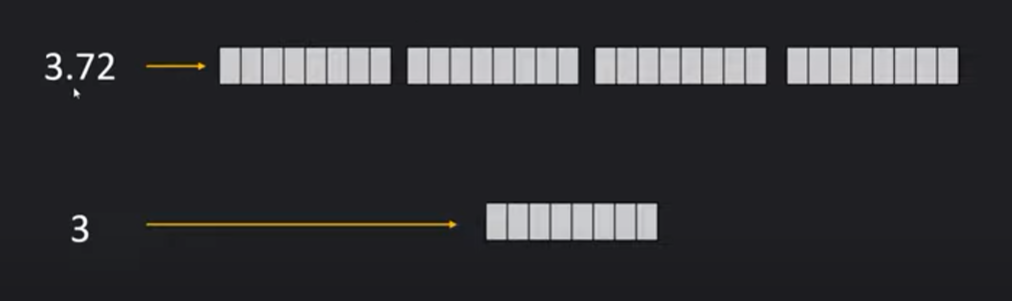

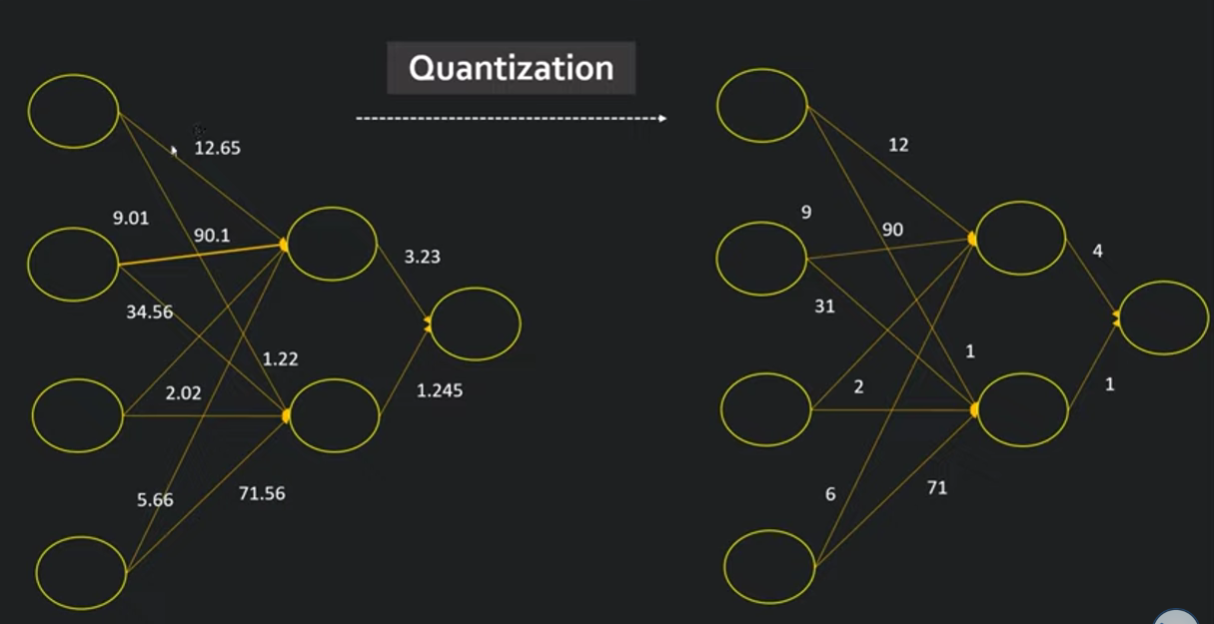

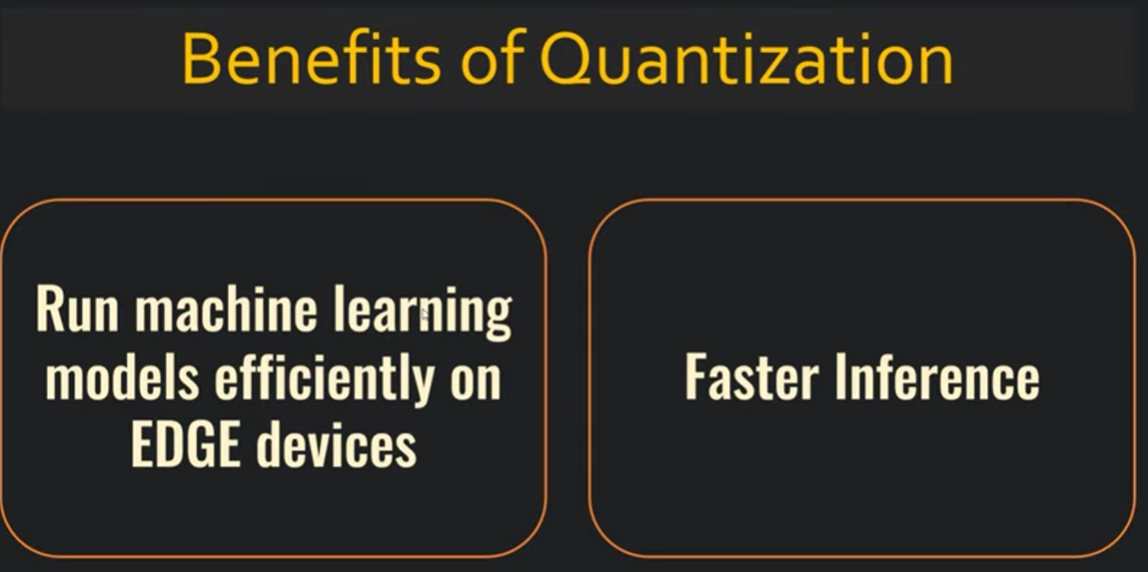

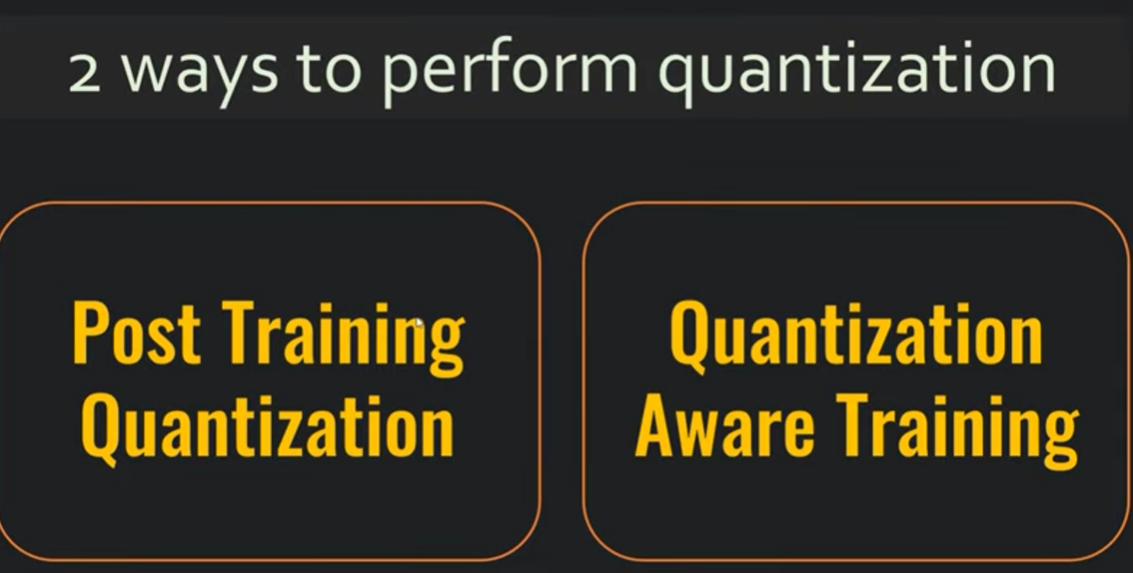

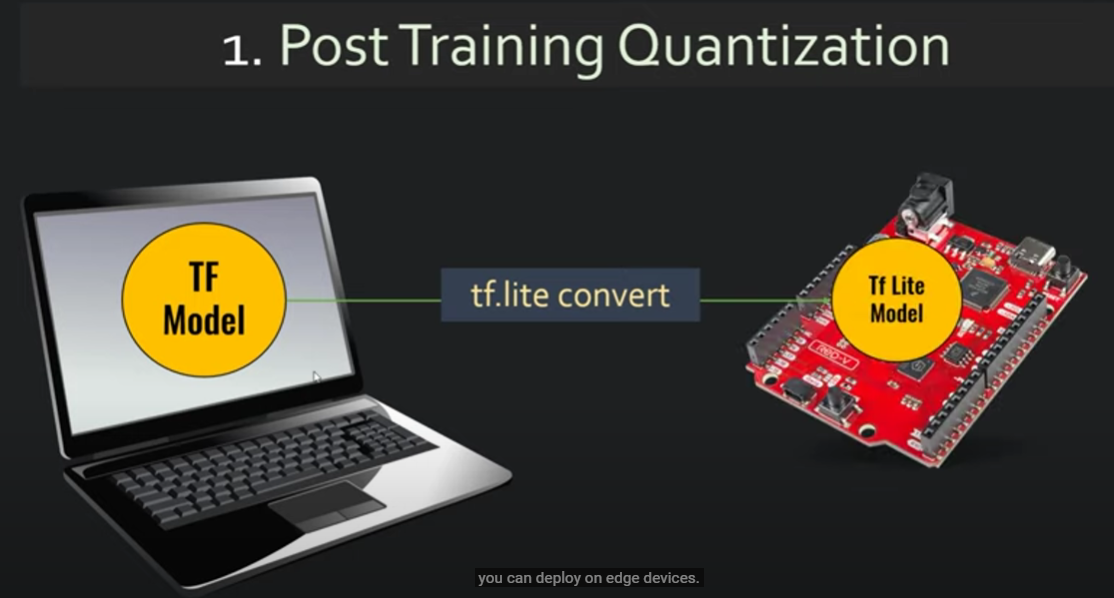

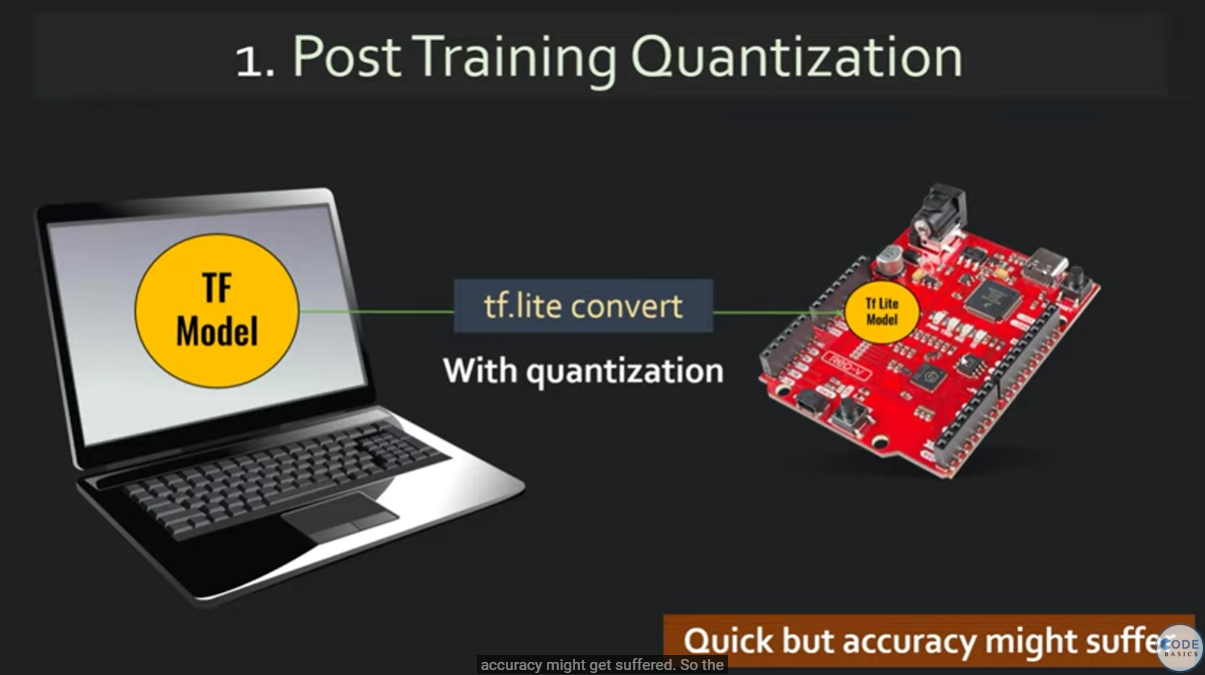
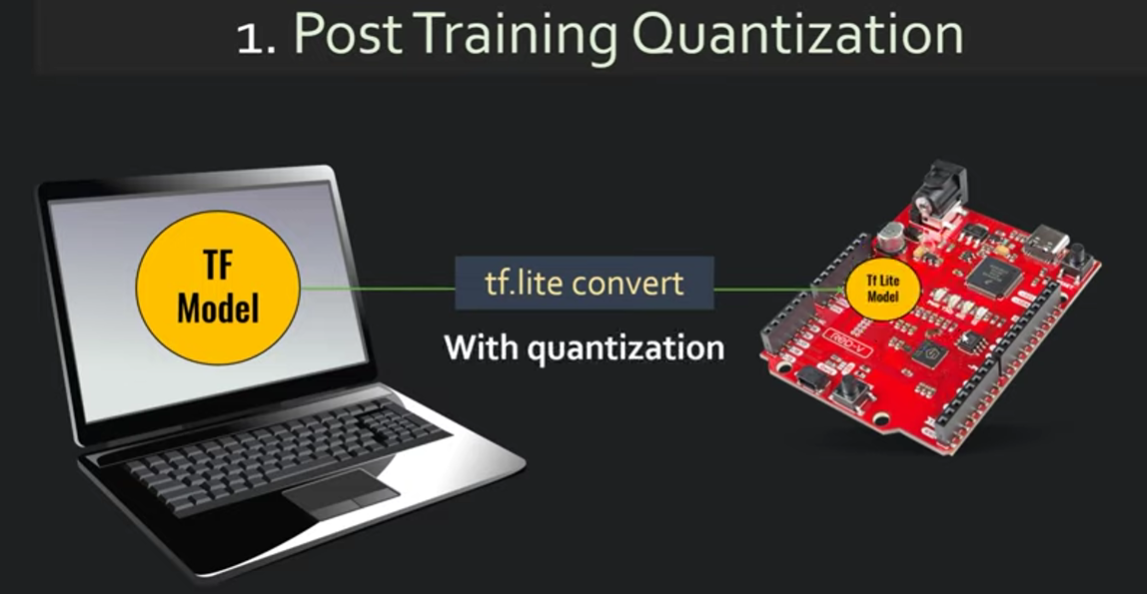

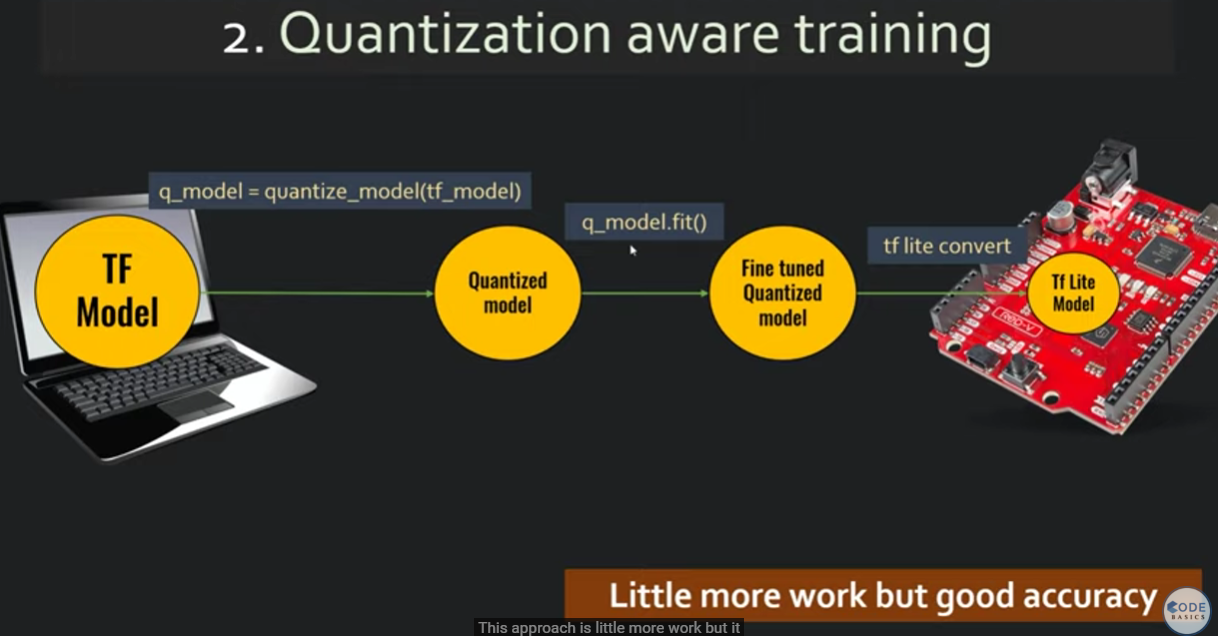

# Quantization Tutorial

Quantization is a technique to downsize a trained model so that you can deploy it on EDGE devices. In this tutorial we will,

(1) Train a hand written digits model

(2) Export to a disk and check the size of that model

(3) Use two techniques for quantization (1) post training quantization (3) quantization aware training

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
len(X_train)

60000

In [4]:
len(X_test)

10000

In [5]:
X_train[0].shape

(28, 28)

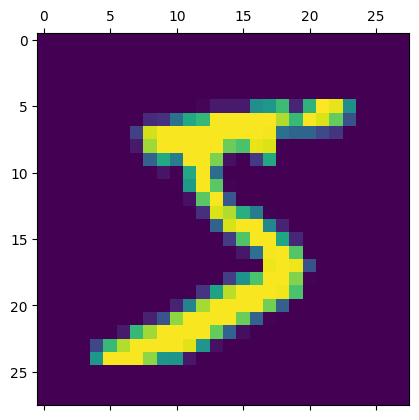

In [6]:
plt.matshow(X_train[0])

In [7]:
y_train[0]

5

In [8]:
X_train = X_train / 255
X_test = X_test / 255

In [9]:
X_train_flattened = X_train.reshape(len(X_train), 28*28)
X_test_flattened = X_test.reshape(len(X_test), 28*28)

In [10]:
X_train_flattened.shape

(60000, 784)

## Using Flatten layer so that we don't have to call .reshape on input dataset

In [11]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 7s 2ms/step - loss: 0.2711 - accuracy: 0.9225
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1234 - accuracy: 0.9638
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0860 - accuracy: 0.9742
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0658 - accuracy: 0.9799
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0525 - accuracy: 0.9837


In [12]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0795 - accuracy: 0.9757


[0.07953903079032898, 0.9757000207901001]

In [13]:
model.save("./saved_model/")

INFO:tensorflow:Assets written to: ./saved_model/assets


## (1) Post training quantization
Without quantization

In [14]:
tflite_model=tf.lite.TFLiteConverter.from_saved_model("./saved_model/").convert()

In [15]:
len(tflite_model)/1024 #kb

312.50390625

In [16]:
converter=tf.lite.TFLiteConverter.from_saved_model("./saved_model")
converter.optimizations=[tf.lite.Optimize.DEFAULT]
tflite_quant_model=converter.convert()

In [17]:
len(tflite_quant_model) / 1024 #kb

82.890625

Read this article for post training quantization: https://www.tensorflow.org/model_optimization/guide/quantization/post_training

In [18]:
with open("tflite_model.tflite", "wb") as f:
    f.write(tflite_model)

In [19]:
with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

## (2) Quantization aware training

In [21]:
import tensorflow_model_optimization as tfmot

quantize_model=tfmot.quantization.keras.quantize_model

q_aware_model=quantize_model(model)

q_aware_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

q_aware_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 28, 28)           3         
 er)                                                             
                                                                 
 quant_flatten (QuantizeWrap  (None, 784)              1         
 perV2)                                                          
                                                                 
 quant_dense (QuantizeWrappe  (None, 100)              78505     
 rV2)                                                            
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 10)               1015      
 perV2)                                                          
                                                                 
Total params: 79,524
Trainable params: 79,510
Non-traina

In [22]:
q_aware_model.fit(X_train,y_train,epochs=1)

1875/1875 [==============================] - 12s 6ms/step - loss: 0.0434 - accuracy: 0.9864


In [23]:
q_aware_model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0780 - accuracy: 0.9745


[0.07801789790391922, 0.9745000004768372]

In [24]:
# use keras model if you are loading in memory model
converter=tf.lite.TFLiteConverter.from_keras_model(q_aware_model)  
converter.optimizations=[tf.lite.Optimize.DEFAULT]
tflite_quant_model=converter.convert()

INFO:tensorflow:Assets written to: C:\Users\91630\AppData\Local\Temp\tmp8lk_ze7s\assets


INFO:tensorflow:Assets written to: C:\Users\91630\AppData\Local\Temp\tmp8lk_ze7s\assets
c:\Users\91630\.conda\envs\tf1\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [25]:
with open("tflite_qaware_model.tflite",'wb') as f:
    f.write(tflite_quant_model)

In [28]:
len(tflite_quant_model) / 1024 # kb
# with much better accuracy

80.796875